**Setup**

In [1]:
import kagglehub
path1 = kagglehub.dataset_download("mdriyadhossain/ai-medleafx")

print("Path to dataset files:", path1)

Path to dataset files: /kaggle/input/ai-medleafx


In [2]:
import kagglehub
path2 = kagglehub.dataset_download("mdriyadhossain/ai-medleafx-augmented")

print("Path to dataset files:", path2)

Path to dataset files: /kaggle/input/ai-medleafx-augmented


**Import**

In [3]:
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import imagehash, seaborn as sns

base = Path('/kaggle/input/ai-medleafx/Resized Image')
sns.set(style='whitegrid')


**Gather Paths**

In [4]:
paths = []
for src in base.iterdir():
    for cls in src.iterdir():
        for img in cls.glob('*.jpg'):
            paths.append((str(img), src.name, cls.name))
df = pd.DataFrame(paths, columns=['path','source','class'])
print(df.groupby('class').size())


class
Bacterial Spot    1281
Healthy Leaf      2842
Powdery Mildew     854
Shot Hole         1359
Shot Hole Leaf     834
Yellow Leaf       1668
dtype: int64


**Extract Core Stats**

In [5]:
rows=[]
for p,s,c in tqdm(paths):
    img = cv2.imread(p)
    if img is None: continue
    h,w = img.shape[:2]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    mean_rgb = rgb.mean(axis=(0,1)); std_rgb = rgb.std(axis=(0,1))
    mean_hsv = hsv.mean(axis=(0,1)); std_hsv = hsv.std(axis=(0,1))
    brightness, contrast = mean_hsv[2], std_hsv[2]
    sat_low = np.mean(hsv[:,:,1]<=1); sat_high = np.mean(hsv[:,:,1]>=254)
    sharp = cv2.Laplacian(gray, cv2.CV_64F).var()
    blur = cv2.GaussianBlur(gray,(5,5),0)
    noise = (gray-blur).std()
    phash = str(imagehash.phash(Image.fromarray(rgb)))
    rows.append([p,s,c,w,h,w/h,*mean_rgb,*std_rgb,*mean_hsv,*std_hsv,brightness,contrast,sat_low,sat_high,sharp,noise,phash])

cols = ['path','source','class','w','h','aspect','r_mean','g_mean','b_mean','r_std','g_std','b_std','h_mean','s_mean','v_mean','h_std','s_std','v_std','brightness','contrast','sat_low','sat_high','sharp','noise','phash']
stats = pd.DataFrame(rows, columns=cols)


100%|██████████| 8838/8838 [15:14<00:00,  9.66it/s]


**RGB/HSV Distributions**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

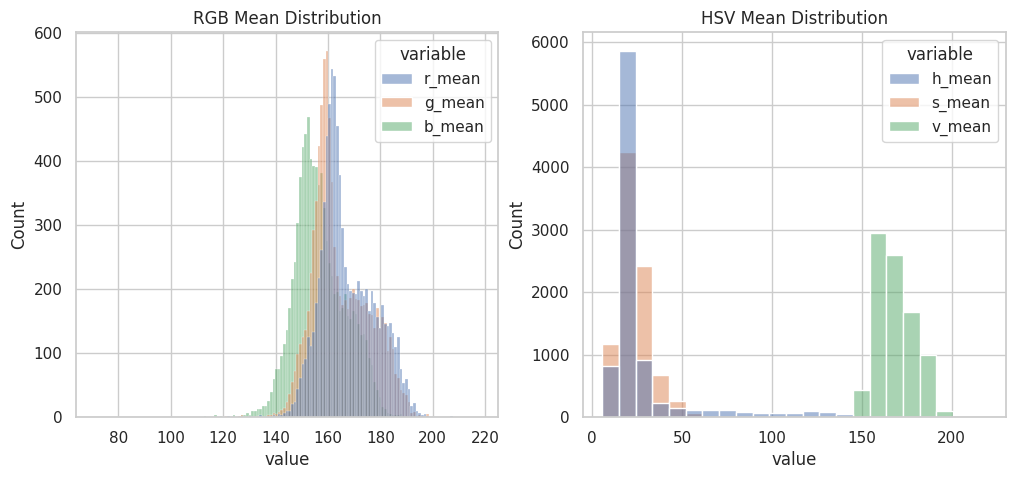

In [6]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.histplot(stats[['r_mean','g_mean','b_mean']].melt(),x='value',hue='variable',ax=ax[0])
ax[0].set_title('RGB Mean Distribution')
sns.histplot(stats[['h_mean','s_mean','v_mean']].melt(),x='value',hue='variable',ax=ax[1])
ax[1].set_title('HSV Mean Distribution')
plt.show()


**Color Channel Analysis of MedLeafX Dataset**

We performed an exploratory data analysis (EDA) of the color characteristics of the images in the MedLeafX dataset. Specifically, we analyzed the mean color values in both RGB and HSV color spaces.

**RGB Mean Distribution**

The left plot shows the distribution of the mean Red, Green, and Blue (RGB) values across all images.

**Observation:**

R_mean (Red) values are centered around 160–180.

G_mean (Green) values cluster around 150–170.

B_mean (Blue) values are slightly lower, mostly around 140–160.

**Interpretation:**

The images have a generally warm tone, with red dominating slightly over blue.

This is typical for leaf datasets where green is strong but some images may include brown or red shades due to leaf disease or variation.



**HSV Mean Distribution**

The right plot shows the distribution of mean Hue (H), Saturation (S), and Value (V) for all images.

**Observation:**

H_mean (Hue) and S_mean (Saturation) are mostly concentrated at lower values (0–50), indicating that most pixels are in a greenish hue range but not very saturated.

V_mean (Value / brightness) is higher, mostly around 150–200, indicating overall bright images.

**Interpretation:**

The dataset has fairly bright leaf images with moderate color intensity.

Low Hue & Saturation but high Value suggests a dominance of lighter green tones.

**Brightness / Contrast / Saturation Clipping**

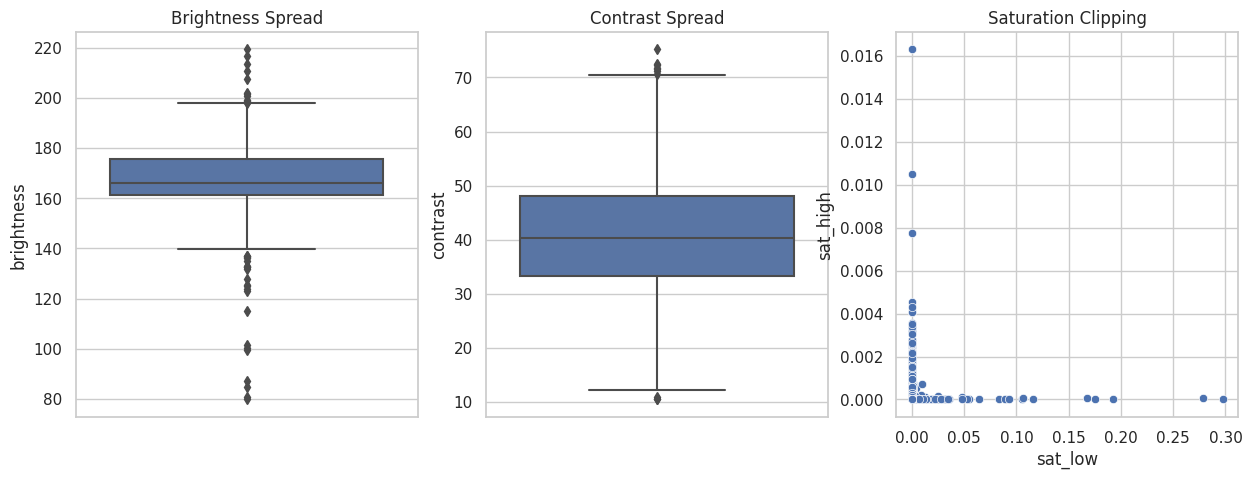

In [7]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
sns.boxplot(y=stats['brightness'],ax=ax[0]); ax[0].set_title('Brightness Spread')
sns.boxplot(y=stats['contrast'],ax=ax[1]); ax[1].set_title('Contrast Spread')
sns.scatterplot(x='sat_low',y='sat_high',data=stats,ax=ax[2]); ax[2].set_title('Saturation Clipping')
plt.show()


**Brightness Spread (Left Boxplot)**


**Interpretation:**

The median brightness is around 165–170, meaning most images are moderately bright.

There are many outliers on both ends — some images are too dark (below 100) and some too bright (above 200).

This suggests uneven lighting conditions or varying exposure in the dataset.

**Insight:** If this dataset is for machine learning or image recognition, normalization of brightness might be needed to ensure consistent model performance.

**Contrast Spread (Middle Boxplot)**

**Interpretation:**

The median contrast is around 40, with most values between 30–50.

A few outliers have very low contrast (~10–15) or very high (~70+).

Indicates that some images are washed out or overly sharp, but most have decent contrast.

**Insight:** Contrast normalization or histogram equalization might improve overall dataset uniformity.

**Saturation Clipping (Right Scatter Plot)**

**Feature:** Saturation clipping (sat_low vs sat_high)

sat_low: Fraction of pixels with very low saturation (nearly grayscale).

sat_high: Fraction of pixels with extremely high saturation (overly vivid colors).

**Interpretation:**

Most points are clustered near (0, 0) — meaning few images have excessive saturation issues.

A few images have slightly higher sat_low values, implying they are desaturated or dull.

**Insight:** The dataset generally has balanced color saturation, with minor cases of desaturation.

**Resolution & Aspect Ratio**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


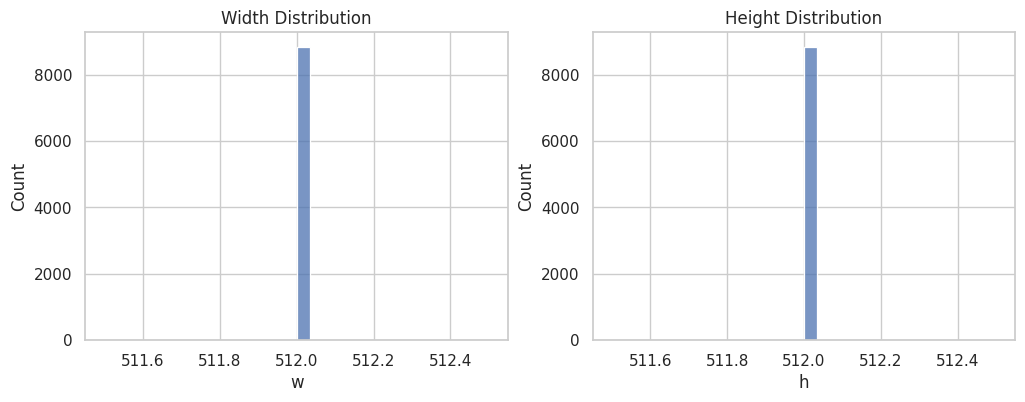

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.histplot(stats['w'], bins=30, ax=ax[0])
ax[0].set_title("Width Distribution")
sns.histplot(stats['h'], bins=30, ax=ax[1])
ax[1].set_title("Height Distribution")
plt.show()

This Histogram plot shows us that every image has exactly the same width and length which is 512x512 . 

**Sharpness & Noise**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


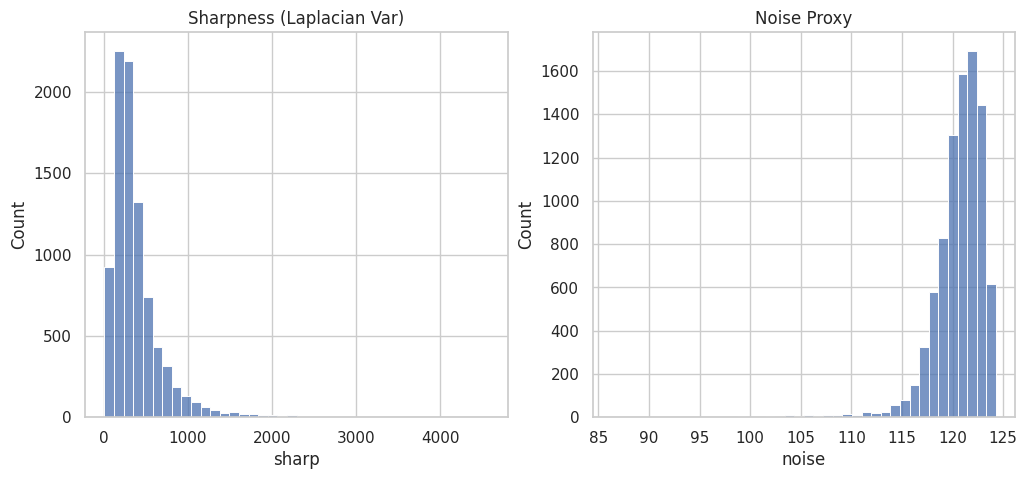

In [9]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
sns.histplot(stats['sharp'],bins=40,ax=ax[0]); ax[0].set_title('Sharpness (Laplacian Var)')
sns.histplot(stats['noise'],bins=40,ax=ax[1]); ax[1].set_title('Noise Proxy')
plt.show()


**Sharpness (Laplacian Variance) – Left Histogram**

**Feature:** Sharpness (measured via Laplacian variance — a common edge-detection-based metric).

**Interpretation:**

The distribution is heavily right-skewed, meaning most images have low sharpness values, with a few having very high sharpness (outliers).

A Laplacian variance near 0–500 indicates blurry or low-detail images, while higher values (e.g., >1000) mean clear, well-focused images.

Since most data points lie in the lower range, your dataset likely includes many slightly blurred or low-detail images.

**Insight:** It may be necessary to remove or enhance blurry samples for tasks that depend on fine texture or edge detail.

**Noise Proxy – Right Histogram**

**Feature:** Noise level proxy (a numerical estimate of random pixel intensity variation).

**Interpretation:**

The distribution is narrow and roughly normal, centered around 120.

This indicates that most images have consistent noise levels, with only a few being significantly noisier or smoother.

The range (≈85–125) suggests low to moderate noise across the dataset.

**Insight:** The dataset maintains a fairly uniform noise profile, so noise likely won’t strongly bias model performance.

**White Balance (Gray-World Check)**

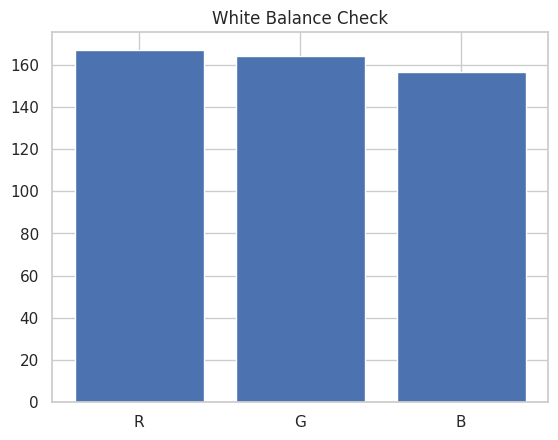

RGB mean ratio: r_mean    1.026823
g_mean    1.009724
b_mean    0.963452
dtype: float64


In [10]:
avg_rgb = stats[['r_mean','g_mean','b_mean']].mean()
plt.bar(['R','G','B'], avg_rgb); plt.title('White Balance Check'); plt.show()
print('RGB mean ratio:', avg_rgb/avg_rgb.mean())


**Insight:**
The dataset shows a minor red-green dominance and a slight blue deficiency, which could give images a warm (reddish-yellow) tint. However, the deviation is relatively small and unlikely to cause major visual distortions. Color balance is mostly consistent across the dataset, with only a slight warm bias due to stronger red and green components so white balance is close to neutral.


**Duplicate Detection**

In [11]:
dupes = stats[stats.duplicated('phash',keep=False)].sort_values('phash')
dupes.head(10)

,path,source,class,w,h,aspect,r_mean,g_mean,b_mean,r_std,...,h_std,s_std,v_std,brightness,contrast,sat_low,sat_high,sharp,noise,phash
66,/kaggle/input/ai-medleafx/Resized Image/Sojina...,Sojina,Yellow Leaf,512,512,1.0,160.028275,156.220810,149.785942,14.953594,...,2.228038,17.617027,14.953624,160.028305,14.953624,0.000000,0.000008,150.754179,122.804579,868c59f366cc9933
163,/kaggle/input/ai-medleafx/Resized Image/Sojina...,Sojina,Yellow Leaf,512,512,1.0,159.226933,155.918411,149.662823,15.953504,...,2.741270,21.067908,15.953264,159.227245,15.953264,0.000000,0.000034,179.011365,122.978653,868c59f366cc9933
564,/kaggle/input/ai-medleafx/Resized Image/Sojina...,Sojina,Yellow Leaf,512,512,1.0,156.369686,152.919476,146.892197,16.048074,...,2.554639,18.383691,16.048339,156.370148,16.048339,0.000000,0.000092,200.973521,122.894219,868c59f366cc9933
3456,/kaggle/input/ai-medleafx/Resized Image/Neem/H...,Neem,Healthy Leaf,512,512,1.0,177.550468,176.120110,165.834450,44.495581,...,4.340096,21.134282,43.544244,177.936016,43.544244,0.000000,0.000031,253.108419,120.907624,90904fcf3031cfcf
2756,/kaggle/input/ai-medleafx/Resized Image/Neem/Y...,Neem,Yellow Leaf,512,512,1.0,194.363499,189.378063,182.123089,29.891815,...,8.257076,28.132905,29.441090,194.516464,29.441090,0.000000,0.000015,177.216589,119.145708,90904fcf3031cfcf
5116,/kaggle/input/ai-medleafx/Resized Image/Neem/S...,Neem,Shot Hole Leaf,512,512,1.0,178.933041,174.906815,166.188545,36.900441,...,4.699028,17.843400,36.260684,179.137226,36.260684,0.000000,0.000000,233.425481,120.105944,90c5c73c38c3ce3d
5137,/kaggle/input/ai-medleafx/Resized Image/Neem/S...,Neem,Shot Hole Leaf,512,512,1.0,178.951237,175.286026,166.170212,36.734594,...,4.332454,18.030253,36.041645,179.174622,36.041645,0.000000,0.000000,237.626122,120.765816,90c5c73c38c3ce3d
4653,/kaggle/input/ai-medleafx/Resized Image/Neem/S...,Neem,Shot Hole Leaf,512,512,1.0,174.176731,173.208309,166.241268,38.919710,...,5.630523,24.262923,37.332015,174.813869,37.332015,0.000015,0.000000,204.823730,121.056272,9184cce33398cfcd
4996,/kaggle/input/ai-medleafx/Resized Image/Neem/S...,Neem,Shot Hole Leaf,512,512,1.0,176.345886,172.500069,165.075932,37.685482,...,5.960229,23.839955,36.331709,176.865555,36.331709,0.000053,0.000000,166.904068,119.178679,9184cce33398cfcd
3133,/kaggle/input/ai-medleafx/Resized Image/Neem/Y...,Neem,Yellow Leaf,512,512,1.0,155.108868,149.782352,142.972317,23.537562,...,5.302045,33.414398,23.423040,155.143303,23.423040,0.000000,0.000027,115.505124,117.067940,9fe0c01f3fe0c01f


The duplicate detection analysis using perceptual hashing successfully identifies visually identical images across different dataset classes and folders. Cleaning these duplicates is crucial to prevent bias and ensure the dataset’s integrity and generalization capacity during model training.

**Class Balance**

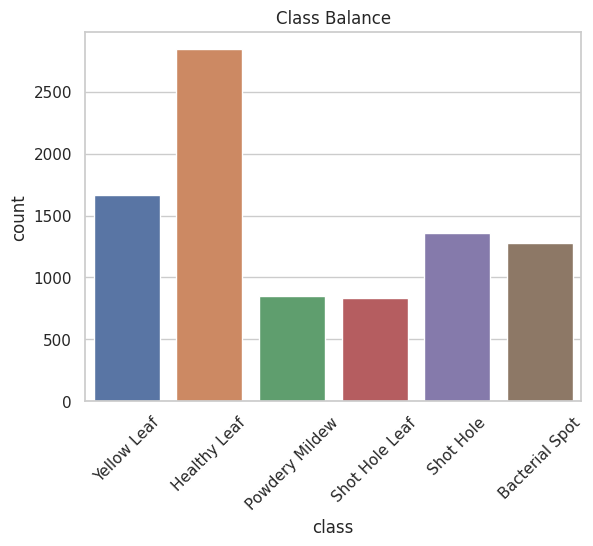

In [12]:
sns.countplot(x='class',data=stats); plt.title('Class Balance'); plt.xticks(rotation=45); plt.show()

**Leakage Safeguards**

In [13]:
stats.groupby('source')['class'].nunique()


source
Camphor     3
HariTaki    3
Neem        4
Sojina      2
Name: class, dtype: int64

**Export Summary Tables**

In [14]:
summary = stats.groupby('class')[['r_mean','g_mean','b_mean','brightness','contrast','sharp','noise']].agg(['mean','std'])
summary.to_csv('class_summary.csv')
summary.head()


r_mean                 g_mean                 b_mean  \
                      mean        std        mean        std        mean   
class                                                                      
Bacterial Spot  160.709394   7.254885  157.333899   6.978471  152.180446   
Healthy Leaf    170.283206  10.622789  167.525102  11.178234  159.329787   
Powdery Mildew  169.853415   9.532785  167.376122   9.538097  160.584658   
Shot Hole       166.328184  10.842942  163.423055  10.995412  155.741638   
Shot Hole Leaf  167.713791  10.799666  165.256113  11.042078  157.806967   

                           brightness              contrast             \
                      std        mean        std       mean        std   
class                                                                    
Bacterial Spot   7.987259  162.170847   7.037392  47.306542   7.453253   
Healthy Leaf    11.356366  171.587489  10.600217  39.743889  10.565371   
Powdery Mildew   7.606752  170.744393   9.343383  39.319775   5.718343   
Shot Hole       10.203501  167.806501  10.385852  50.127298   6.925815   
Shot Hole Leaf   9.560959  168.536241  10.817318  38.926528   4.682007   

                     sharp                   noise            
                      mean         std        mean       std  
class                                                         
Bacterial Spot  615.846366  290.421951  121.084274  1.570561  
Healthy Leaf    295.189578  270.963537  120.039965  3.702568  
Powdery Mildew  345.656387  143.484396  121.083321  1.726488  
Shot Hole       643.302730  465.377881  119.638126  1.871179  
Shot Hole Leaf  290.559146  111.266290  120.798671  2.061161